# Pulse Shaping

Pulse shaping is an essential part of the wireless transmitter as it shapes the outgoing symbols in a way that bandlimits the signal, minimizing spectral leakage to adjacent channels.

In [1]:
import sys
sys.path.insert(0, '../')
from comms import awgn

import numpy as np
import matplotlib.pyplot as plt

## Square Pulse Shape

Technically all previous examples, where we applied upsampling, have been pulse shaped with what is called a "square" pulse shape.

<StemContainer object of 3 artists>

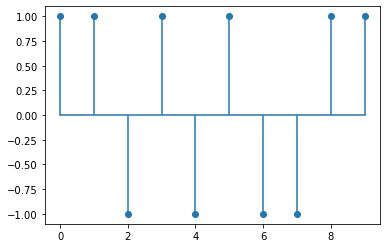

In [2]:
# Create some pulses (or symbols)
bits = np.random.randint(0, 2, 10000)
pulses = np.array([1 if x==1 else -1 for x in bits])
plt.stem(pulses[:10], basefmt="-")

We create a square pulse shape by simply repeating the pulses (symbols). Now the pulses look somewhat like square shapes, hence the name.

<StemContainer object of 3 artists>

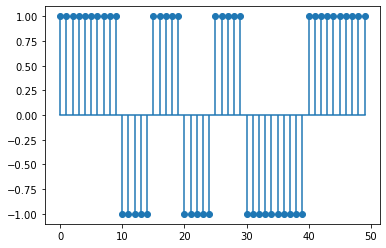

In [3]:
plt.stem(np.repeat(pulses[:10],5), basefmt="-")

### Sinc

In practice pulse shaping involves filtering symbols with a sinc-based pulse shaping filter. While a square shape will not prevent any spectral leakage, the filters based on the sinc shape are often used to effectively bandlimit transmitted signals according to various regulatory standards.

The sinc function is defined as:

$sinc(x) = \frac{sin(x)}{x}$

However the sinc function implemented in numpy `np.sinc()` is

$sinc(x) = \frac{sin(\pi x)}{\pi x}$

Below is an example of creating a simple 65 weight sinc filter:

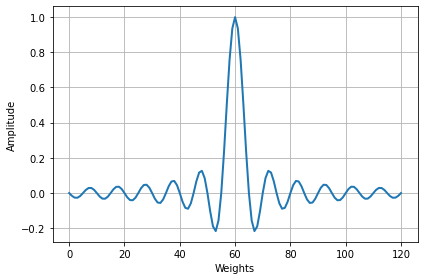

In [4]:
T = 1 # sample period
sps = 5 # symbol period in samples
num_weights = 121
x = np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/sps/T
sinc_weights = np.sinc(x)
# sinc_weights = sinc_weights/np.max(sinc_weights)
plt.plot(sinc_weights, linewidth=2)
plt.xlabel('Weights'); plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid()
# plt.savefig('figures/sinc.png', dpi=300, bbox_inches='tight')

In order to apply sinc pulse shaping to the pulses, we convolve the filter weights with the samples of the input stream.

In [5]:
square_pulses = np.repeat(pulses,10)
sinc_pulses = np.convolve(square_pulses, sinc_weights, mode='full')

In order to overlay the pulse shaped signals over each other we need to perform some indexing shenanigans due to transients and what have you.

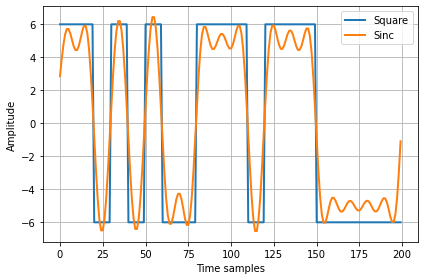

In [6]:
# plt.figure(figsize=(7,4))
plt.plot(square_pulses[:200]*6, linewidth=2)
plt.plot(sinc_pulses[int((len(sinc_weights)-1)/2):int((len(sinc_weights)-1)/2)+200], linewidth=2)
plt.grid()
plt.xlabel('Time samples'); plt.ylabel('Amplitude')
plt.legend(('Square', 'Sinc'), loc='upper right')
plt.tight_layout()
# plt.savefig('figures/square_vs_pulse_time.png', dpi=300, bbox_inches='tight')

It may not seem obvious from the time series plots why the pulse shape is advantageous. It will become clearer after we apply an FFT to the pulses.

### Pulse shaping in frequency domain

Using the previously generated pulse shaped signals let's compare the FFTs. First lets plot the FFT of the square pulse shaped symbols.

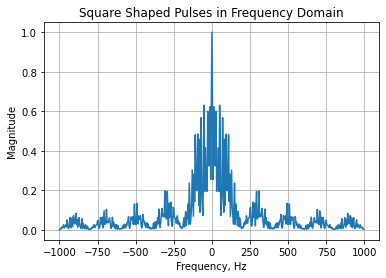

In [8]:
fs = 2000
fft_size = 512

y_fft = np.fft.fft(square_pulses,fft_size)
y_fft_square = np.fft.fftshift(y_fft)#[int(fft_size/2):]
freqs_fft = np.fft.fftfreq(fft_size,1/fs)
freqs = np.fft.fftshift(freqs_fft)#[int(fft_size/2):]

# Plot the result
plt.plot(freqs, np.abs(y_fft_square)/np.max(np.abs(y_fft_square)))
plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude')
plt.title('Square Shaped Pulses in Frequency Domain')
# plt.ylim((0,50))
plt.grid()
plt.show()

Note that this signal occupies the entire observable bandwidth. 

Now for the sinc pulse shaped signal.

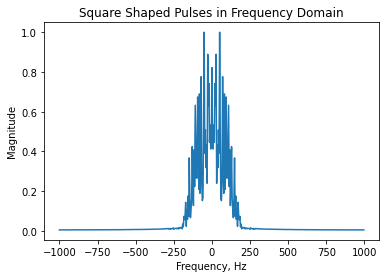

In [9]:
fft_size = 512

y_fft = np.fft.fft(sinc_pulses,fft_size)
y_fft_sinc = np.fft.fftshift(y_fft)#[int(fft_size/2):]
freqs_fft = np.fft.fftfreq(fft_size,1/fs)
freqs = np.fft.fftshift(freqs_fft)#[int(fft_size/2):]

# Plot the result
plt.plot(freqs, np.abs(y_fft_sinc)/np.max(np.abs(y_fft_sinc)))
plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude')
plt.title('Square Shaped Pulses in Frequency Domain')
plt.show()

Much better! Because of the pulse shaping there are no more sharp transitions between the symbols which translates into a much nicer frequency response.

We can also overlay the 2 plots on top of each other for a better view.

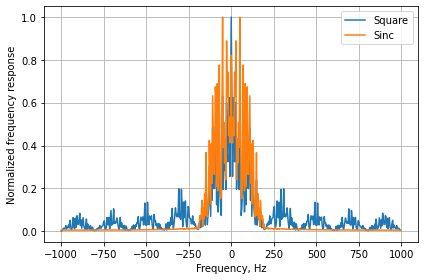

In [10]:
plt.plot(freqs, np.abs(y_fft_square)/np.max(np.abs(y_fft_square)))
plt.plot(freqs, np.abs(y_fft_sinc)/np.max(np.abs(y_fft_sinc)))
plt.legend(('Square','Sinc'))
plt.grid()
plt.xlabel('Frequency, Hz'); plt.ylabel('Normalized frequency response')
plt.tight_layout()
# plt.savefig('figures/square_vs_pulse_freq.png', dpi=300, bbox_inches='tight')

That's the motivation behind pulse shaping. There are many more pulse shape types, like Raised Cosine, which allows various ways to tune it for different bandwidths. 

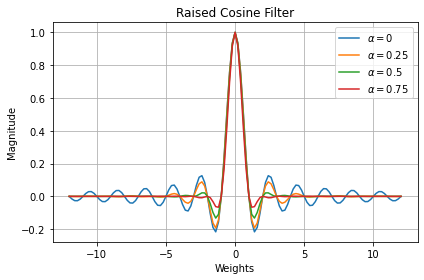

In [11]:
sps = 5
num_weights = 121
x = 0.9999*np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/sps

alphas = [0, 0.25, 0.5, 0.75]
for alpha in alphas:
    raised_cos_weights = np.sinc(x)*(np.cos(alpha*np.pi*x)/(1-((2*alpha*x)**2)))
    plt.plot(x,raised_cos_weights)

plt.legend((r'$\alpha = 0$', r'$\alpha = 0.25$', r'$\alpha = 0.5$', r'$\alpha = 0.75$'))
plt.ylabel('Magnitude')
plt.xlabel('Weights')
plt.title('Raised Cosine Filter')
plt.grid()
plt.tight_layout()
# plt.savefig('figures/raised_cosine_alpha.png', dpi=300, bbox_inches='tight')

Note that a rolloff factor $\alpha=0$ is the same as the sinc. We can also visualize how $\alpha$ affects the filter response in the frequency domain, which is what we care about for bandlimiting channels.

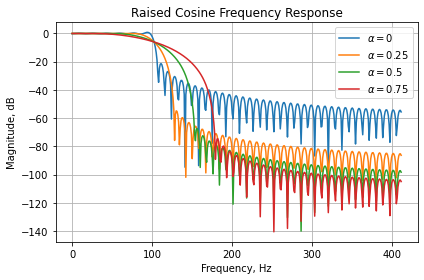

In [12]:
sps = 5
num_weights = 121
fft_size = 1024

x = 0.9999*np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/sps

alphas = [0, 0.25, 0.5, 0.75]


for alpha in alphas:
    raised_cos_weights = np.sinc(x)*(np.cos(alpha*np.pi*x)/(1-((2*alpha*x)**2)))

    rcos_response = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(raised_cos_weights, fft_size)))/sps)
    plt.plot(rcos_response[int(fft_size/2):-100])
    
plt.legend((r'$\alpha = 0$', r'$\alpha = 0.25$', r'$\alpha = 0.5$', r'$\alpha = 0.75$'))
plt.title('Raised Cosine Frequency Response')
plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude, dB')
plt.grid()
plt.tight_layout()
# plt.savefig('figures/raised_cosine_response.png', dpi=300, bbox_inches='tight')

In practice the RC filter is often split into 2 parts, 1 for the transmitter and 1 for the receiver. This is called the Root Raised Cosine (RRC). The RC filter has no ISI, however RRC does introduce ISI (as shown in Figure below). Once you pass through the RRC filter a second time, ISI is removed.

<ipython-input-15-df278d54f0d3>:10: RuntimeWarning: invalid value encountered in true_divide
  h_rrc = 1/Ts*(np.sin(np.pi*x*(1-alpha)) + 4*alpha*x*np.cos(np.pi*x*(1+alpha)))/(np.pi*x*(1-(4*alpha*x)**2))


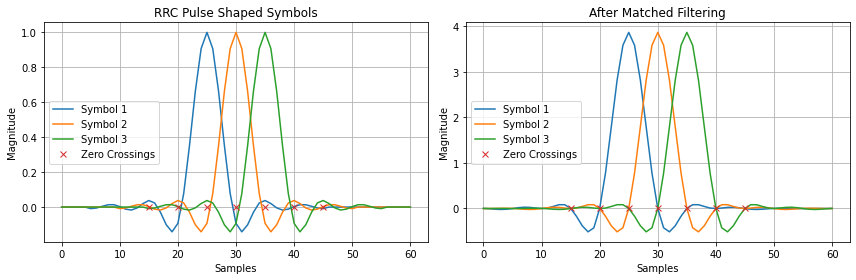

In [15]:
# Base parameters, same as rcos in the previous example
fs = 5
Ts =  1/fs
alpha = 0.5

num_weights = 41
x = np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/fs

# Impulse response according to definition
h_rrc = 1/Ts*(np.sin(np.pi*x*(1-alpha)) + 4*alpha*x*np.cos(np.pi*x*(1+alpha)))/(np.pi*x*(1-(4*alpha*x)**2))

# Find and replace the center weight according to the first part of the formula
h_rrc[int(num_weights/2)] = 1/Ts*(1+alpha*(4/np.pi - 1))

# Normalize the weights
h_rrc = h_rrc/np.max(h_rrc)

# Generate pulse vectors
pulse1 = np.zeros(21,)
pulse2 = np.zeros(21,)
pulse3 = np.zeros(21,)
pulse1[5] = 1
pulse2[10] = 1
pulse3[15] = 1

# Pulse shape each symbol separately 
symbol1_rrc = np.convolve(pulse1,h_rrc).real
symbol2_rrc = np.convolve(pulse2,h_rrc).real
symbol3_rrc = np.convolve(pulse3,h_rrc).real

# Pulse shape with matched filter
symbol1_matched = np.convolve(symbol1_rrc,h_rrc).real[20:-20]
symbol2_matched = np.convolve(symbol2_rrc,h_rrc).real[20:-20]
symbol3_matched = np.convolve(symbol3_rrc,h_rrc).real[20:-20]

# Plot them all
fig, ax = plt.subplots(1,2, figsize=(12,4))

# Only RRC filtered pulses
ax[0].plot(symbol1_rrc)
ax[0].plot(symbol2_rrc)
ax[0].plot(symbol3_rrc)
ax[0].plot([15,20,25,30,35,40,45], [0,0,0,0,0,0,0], 'x')
ax[0].set_title('RRC Pulse Shaped Symbols')
ax[0].set_ylabel('Magnitude')
ax[0].set_xlabel('Samples')
ax[0].grid()
ax[0].legend(('Symbol 1', 'Symbol 2', 'Symbol 3', 'Zero Crossings'), loc='center left')

# Twice RRC filtered pulses, demonstrating matched filtering
ax[1].plot(symbol1_matched)
ax[1].plot(symbol2_matched)
ax[1].plot(symbol3_matched)
ax[1].plot([15,20,25,30,35,40,45], [0,0,0,0,0,0,0], 'x')
ax[1].set_title('After Matched Filtering')
ax[1].set_ylabel('Magnitude')
ax[1].set_xlabel('Samples')
ax[1].grid()
ax[1].legend(('Symbol 1', 'Symbol 2', 'Symbol 3', 'Zero Crossings'), loc='center left')
plt.tight_layout()
# plt.savefig('figures/matched_filter.png', dpi=300, bbox_inches='tight')

## Pulse shaped carrier

As you would expect, what pulse shaping does to the carrier signal is a smoothing function. We can see the transitions are less sharp, which translates to tighter frequency domain representations.

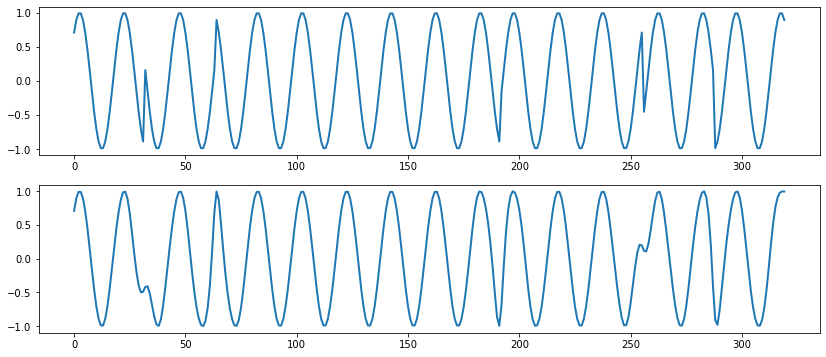

In [ ]:
T = 1 # sample period
sps = 5 # symbol period in samples
num_weights = 131
x = np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/sps/T
sinc_weights = np.sinc(x)

# Arbitrary simulation parameters
num_bits = 10000
fs = 2000
f_c = 100
sps = 32

# Our "bits" are integers in range of [0,3]
bits = np.random.randint(0,4,num_bits)

symbol_dict = {0: +1+1j,
               1: +1-1j,
               2: -1+1j,
               3: -1-1j}

# Map bits to symbols
symbols = np.array(list(map(lambda x:  symbol_dict[x], bits)))

# Perform upsampling and "square" pulse shaping
symbols_upsampled = np.repeat(symbols, sps)
sinc_pulses = np.convolve(symbols_upsampled, raised_cos_weights, mode='same')

# Modulate onto a carrier
carrier_modulated_qpsk = \
np.sin((2*np.pi*f_c)/fs*np.arange(len(symbols_upsampled))+np.angle(symbols_upsampled))

carrier_modulated_qpsk_ps = \
np.sin((2*np.pi*f_c)/fs*np.arange(len(sinc_pulses))+np.angle(sinc_pulses))

# Visualize the discontinuities signifying symbol transitions
# plt.figure(figsize=(10,4))
fig, ax = plt.subplots(2,1, figsize=(14,6))
ax[0].plot(carrier_modulated_qpsk[:10*sps], linewidth=2)
ax[1].plot(carrier_modulated_qpsk_ps[:10*sps], linewidth=2)
# plt.plot(symbols_upsampled.real[2*64:10*64], linewidth=2)
# plt.plot(sinc_pulses.real[2*64:10*64]/6, linewidth=2)